In [3]:
# We will be using satimage data as in the Borderline-SMOTE paper
from sklearn.datasets import fetch_openml
import pandas as pd
import gc

data = fetch_openml(name='satimage')
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

# treat 4 as the target class
y = (y=='4.').astype(int)
y.mean()

del data
gc.collect()

0

## How the baseline model does without any over-sampling

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, recall_score, precision_score, f1_score
from sklearn.ensemble import RandomForestClassifier

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7,
                                                    stratify=y, shuffle=True, random_state=1024)

In [6]:
def evaluate(clf):
    pred_proba = clf.predict_proba(X_test)[:, 1]
    pred = clf.predict(X_test)
    metric = 'AUC: {}\nRecall: {}\nPrecision: {}\nF1: {}\n'.format(roc_auc_score(y_test, pred_proba),
                                                              recall_score(y_test, pred),
                                                              precision_score(y_test, pred),
                                                              f1_score(y_test, pred))
    print(metric)

In [7]:
clf = RandomForestClassifier(n_estimators=100, random_state=1024)
clf.fit(X_train, y_train)

evaluate(clf)

AUC: 0.9455910029696799
Recall: 0.4946808510638298
Precision: 0.8378378378378378
F1: 0.6220735785953178



## With SMOTE

In [8]:
from imblearn.over_sampling import SMOTE

clf.fit(*SMOTE().fit_resample(X_train, y_train))

evaluate(clf)

Using TensorFlow backend.


AUC: 0.9566677258117736
Recall: 0.6595744680851063
Precision: 0.6458333333333334
F1: 0.6526315789473683



## AutoEncoders?

In [9]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
%matplotlib inline
from IPython import display
from tensorflow import keras

# the nightly build of tensorflow_probability is required as of the time of writing this 
import tensorflow_probability as tfp
ds = tfp.distributions

import warnings
warnings.filterwarnings('ignore')

C:\Users\liuzhehao\AppData\Local\Continuum\anaconda3\envs\dl\lib\site-packages\tqdm\autonotebook\__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [10]:
def standardize(x):
    mean_, var_ = tf.nn.moments(x, axes=[0], keepdims=True)
    return (x - mean_) / tf.sqrt(var_)

In [25]:
N_FEATURE = X_train.shape[1]
BATCH_SIZE = 124

train_dataset =tf.data.Dataset.from_tensor_slices(X_train.values.astype('float32')) \
    .shuffle(10000).batch(BATCH_SIZE).map(standardize)
test_dataset = tf.data.Dataset.from_tensor_slices(X_test.values.astype('float32')) \
    .shuffle(10000).batch(10000).map(standardize)

# all positive samples
train_pos_dataset = tf.data.Dataset.from_tensor_slices(X_train[y_train==1].values.astype('float32')) \
    .shuffle(10000).batch(BATCH_SIZE).map(standardize)
test_pos_dataset = tf.data.Dataset.from_tensor_slices(X_test[y_test==1].values.astype('float32')) \
    .shuffle(10000).batch(100).map(standardize)

In [26]:
sample = next(iter(train_pos_dataset))
sample.shape

TensorShape([124, 36])

In [27]:
def make_encoder_decoder(hidden_size=4, share_hidden=False):
    """ If share hidden is set to False, then the actual hidden_size will be 2 * hidden_size
        and it will split in half into the mean and std vector
    """
    if share_hidden is False:
        hidden_size = hidden_size * 2
        
    encoder = tf.keras.models.Sequential([
        keras.layers.InputLayer(input_shape=(N_FEATURE,)),
        keras.layers.Dense(36, activation=None),
        keras.layers.LeakyReLU(alpha=0.2),
        keras.layers.Dense(18, activation=None),
        keras.layers.LeakyReLU(alpha=0.2),
        keras.layers.Dense(hidden_size)
    ])

    decoder = tf.keras.models.Sequential([
        keras.layers.Dense(18, activation=None),
        keras.layers.LeakyReLU(alpha=0.2),
        keras.layers.Dense(36, activation=None),
        keras.layers.LeakyReLU(alpha=0.2),
        keras.layers.Dense(N_FEATURE)
    ])
    
    return encoder, decoder

In [28]:
# take a look at the encoder and decoders
e_, d_ = make_encoder_decoder()
e_.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 36)                1332      
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 36)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 18)                666       
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 18)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 8)                 152       
Total params: 2,150
Trainable params: 2,150
Non-trainable params: 0
_________________________________________________________________


In [29]:
def check_gradients(gradients):
    """ Handy function to check the gradients, in case we get nans from gradient explotion """
    grad = [i.numpy() for i in gradients]
    if all([np.isfinite(g).all() for g in grad]):
        avg_grad = [np.mean(g) for g in grad]
        mean_, std_ = np.mean(avg_grad), np.std(avg_grad)
        print('Gradients stats: mean={}, std={}'.format(mean_, std_))
    else:
        print('Gradient exploded: {}'.format(grad))

In [166]:
class VAE(tf.keras.Model):
    
    def __init__(self, learning_rate=1e-3, hidden_size=8, share_hidden=False, recon_loss_div=10.0):
        super().__init__()
        self.hidden_size = hidden_size
        self.share_hidden = share_hidden
        self.encoder, self.decoder = make_encoder_decoder(hidden_size, share_hidden)
        self.recon_loss_div = recon_loss_div
        
        # only used when share hidden is True
        self.dense_mean = keras.layers.Dense(hidden_size)
        self.dense_std = keras.layers.Dense(hidden_size)
        
        # use for the weighted sum of latent loss and reconstruction loss
        self.latent_weight = tf.Variable(0.5, dtype=tf.float32, name='recon_loss_weight')
        
        self.learning_rate = tf.Variable(learning_rate, dtype=tf.float32, trainable=False)
        self.optimizer = keras.optimizers.Adam(learning_rate=self.learning_rate)
        
    def reduce_learning_rate(self, factor=2):
        self.learning_rate = self.learning_rate.assign(self.learning_rate / factor)
    
    def encode(self, x):
        encoded = self.encoder(x)
        if self.share_hidden:
            mu, sigma = self.dense_mean(encoded), self.dense_std(encoded)
        else:
            mu, sigma = tf.split(encoded, num_or_size_splits=2, axis=1)
        return mu, sigma, ds.MultivariateNormalDiag(loc=mu, scale_diag=sigma)

    def decode(self, z):
        return self.decoder(z)
    
    def compute_loss(self, x):
        mu, sigma, q_z = self.encode(x)
#         z = sigma * q_z.sample() + mu
        z = q_z.sample()
        x_recon = self.decode(z)
        
        # standard normal distribution
        p_z = ds.MultivariateNormalDiag(loc=[0.] * z.shape[-1], scale_diag=[1.] * z.shape[-1])
        kl_div = ds.kl_divergence(q_z, p_z)
        latent_loss = tf.reduce_mean(tf.maximum(kl_div, 0))
        recon_loss = tf.reduce_mean(tf.reduce_sum(tf.square(x - x_recon), axis=0))
#         return latent_loss, recon_loss, recon_loss / self.recon_loss_div + latent_loss

        latent_weight = tf.clip_by_value(self.latent_weight, 0.1, 0.9)
        recon_weight = 1 - latent_weight
        return latent_loss, recon_loss, recon_weight * recon_loss + latent_weight * latent_loss
    
    def compute_gradients(self, x):
        with tf.GradientTape() as tape:
            latent_loss, recon_loss, loss = self.compute_loss(x)
        gradients = tape.gradient(loss, self.trainable_variables)
        return gradients
#         grad = [g.numpy() for g in gradients]
#         if all([np.isfinite(g).all() for g in grad]):
#             return gradients
#         else:
#             print('Gradient exploded.')
#             return None
        
    @tf.function
    def train(self, train_x):
        gradients = self.compute_gradients(train_x)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

In [ ]:
n_epochs = 1500

# gradually reduce the learning rate
steps_before_reduce_learning_rate = 300
reduce_factor = 2.0

N_TRAIN_BATCHES = y_train.sum() // BATCH_SIZE
N_TEST_BATCHES = y_test.sum() // BATCH_SIZE
EARLY_STOPPING_ROUNDS = 50

losses = pd.DataFrame(columns = ['latent_loss', 'recon_loss', 'loss'])
prev_loss, early_stop_round = np.inf, 0

model = VAE(1e-3, hidden_size=4, share_hidden=False)

for epoch in tqdm(range(n_epochs), total=n_epochs):
    # reduce learning rate
    if (epoch + 1) >= steps_before_reduce_learning_rate and (epoch + 1) % steps_before_reduce_learning_rate == 0:
        model.reduce_learning_rate(reduce_factor)
        print('The learning rate now is: {}'.format(model.learning_rate))

    # train
    for batch, train_x in zip(range(N_TRAIN_BATCHES), train_pos_dataset):
        model.train(train_x)
        
    # test on holdout
    loss = []
    for batch, test_x in zip(range(N_TEST_BATCHES), test_pos_dataset):
        loss.append(model.compute_loss(test_x))
    losses.loc[len(losses)] = np.mean(loss, axis=0)
    
    # early stopping
    round_loss = (losses.recon_loss.values[-1] + losses.latent_loss.values[-1]) / 2
    if round_loss < prev_loss:
        early_stop_round = 0
    else:
        early_stop_round += 1
        if early_stop_round == EARLY_STOPPING_ROUNDS:
            break
    prev_loss = round_loss
    
    print(
        "Epoch: {} | recon_loss: {} | latent_loss: {} | total_loss: {}".format(
           epoch, losses.recon_loss.values[-1], losses.latent_loss.values[-1], round_loss
        ))

Epoch: 0 | recon_loss: 101.55613708496094 | latent_loss: 5.612210273742676 | total_loss: 53.58417510986328
Epoch: 1 | recon_loss: 99.94841766357422 | latent_loss: 5.239713668823242 | total_loss: 52.59406661987305
Epoch: 2 | recon_loss: 98.8521499633789 | latent_loss: 5.099998950958252 | total_loss: 51.97607421875
Epoch: 3 | recon_loss: 97.87281799316406 | latent_loss: 5.136470794677734 | total_loss: 51.50464630126953
Epoch: 4 | recon_loss: 95.87464141845703 | latent_loss: 5.178112983703613 | total_loss: 50.5263786315918
Epoch: 5 | recon_loss: 94.69163513183594 | latent_loss: 5.199558258056641 | total_loss: 49.945594787597656
Epoch: 6 | recon_loss: 92.33568572998047 | latent_loss: 5.2553229331970215 | total_loss: 48.79550552368164
Epoch: 7 | recon_loss: 90.65685272216797 | latent_loss: 5.448147773742676 | total_loss: 48.0525016784668
Epoch: 8 | recon_loss: 87.29712677001953 | latent_loss: 5.506939888000488 | total_loss: 46.402034759521484
Epoch: 9 | recon_loss: 84.53145599365234 | laten

Epoch: 76 | recon_loss: 41.79694366455078 | latent_loss: 6.810222148895264 | total_loss: 24.3035831451416
Epoch: 77 | recon_loss: 41.92538833618164 | latent_loss: 6.742252826690674 | total_loss: 24.333820343017578
Epoch: 78 | recon_loss: 42.68800735473633 | latent_loss: 6.655840873718262 | total_loss: 24.671924591064453
Epoch: 79 | recon_loss: 44.956878662109375 | latent_loss: 6.4778666496276855 | total_loss: 25.71737289428711
Epoch: 80 | recon_loss: 43.20393753051758 | latent_loss: 6.2868733406066895 | total_loss: 24.745405197143555
Epoch: 81 | recon_loss: 43.93116760253906 | latent_loss: 6.2483229637146 | total_loss: 25.089744567871094
Epoch: 82 | recon_loss: 41.65568161010742 | latent_loss: 6.310086250305176 | total_loss: 23.98288345336914
Epoch: 83 | recon_loss: 42.35512924194336 | latent_loss: 6.344081401824951 | total_loss: 24.349605560302734
Epoch: 84 | recon_loss: 43.054447174072266 | latent_loss: 6.2410430908203125 | total_loss: 24.64774513244629
Epoch: 85 | recon_loss: 40.923

Epoch: 151 | recon_loss: 39.453182220458984 | latent_loss: 6.030349254608154 | total_loss: 22.74176597595215
Epoch: 152 | recon_loss: 36.53891372680664 | latent_loss: 6.031999588012695 | total_loss: 21.285457611083984
Epoch: 153 | recon_loss: 38.28887939453125 | latent_loss: 6.051328659057617 | total_loss: 22.17010498046875
Epoch: 154 | recon_loss: 37.73033905029297 | latent_loss: 6.017341136932373 | total_loss: 21.87384033203125
Epoch: 155 | recon_loss: 36.05161666870117 | latent_loss: 5.983509540557861 | total_loss: 21.017562866210938
Epoch: 156 | recon_loss: 37.26445770263672 | latent_loss: 5.985456466674805 | total_loss: 21.624958038330078
Epoch: 157 | recon_loss: 40.74662399291992 | latent_loss: 6.01609992980957 | total_loss: 23.381362915039062
Epoch: 158 | recon_loss: 38.41356658935547 | latent_loss: 5.971153736114502 | total_loss: 22.192359924316406
Epoch: 159 | recon_loss: 39.58557891845703 | latent_loss: 5.983389377593994 | total_loss: 22.78448486328125
Epoch: 160 | recon_loss

Epoch: 226 | recon_loss: 41.22336196899414 | latent_loss: 5.261407852172852 | total_loss: 23.242385864257812
Epoch: 227 | recon_loss: 40.95165252685547 | latent_loss: 5.276694297790527 | total_loss: 23.114173889160156
Epoch: 228 | recon_loss: 37.77178955078125 | latent_loss: 5.225625991821289 | total_loss: 21.498706817626953
Epoch: 229 | recon_loss: 39.11382293701172 | latent_loss: 5.214836597442627 | total_loss: 22.164329528808594
Epoch: 230 | recon_loss: 36.41205978393555 | latent_loss: 5.224729061126709 | total_loss: 20.81839370727539
Epoch: 231 | recon_loss: 38.049190521240234 | latent_loss: 5.208677768707275 | total_loss: 21.628934860229492
Epoch: 232 | recon_loss: 37.766483306884766 | latent_loss: 5.194202423095703 | total_loss: 21.480342864990234
Epoch: 233 | recon_loss: 39.924129486083984 | latent_loss: 5.198178768157959 | total_loss: 22.561153411865234
Epoch: 234 | recon_loss: 38.912147521972656 | latent_loss: 5.178580284118652 | total_loss: 22.045364379882812
Epoch: 235 | rec

Epoch: 300 | recon_loss: 39.68938446044922 | latent_loss: 4.998510360717773 | total_loss: 22.343948364257812
Epoch: 301 | recon_loss: 39.15959167480469 | latent_loss: 5.003299236297607 | total_loss: 22.081445693969727
Epoch: 302 | recon_loss: 38.74342727661133 | latent_loss: 5.000336647033691 | total_loss: 21.87188148498535
Epoch: 303 | recon_loss: 39.37421798706055 | latent_loss: 4.993684768676758 | total_loss: 22.18395233154297
Epoch: 304 | recon_loss: 38.88850402832031 | latent_loss: 5.002788066864014 | total_loss: 21.945646286010742
Epoch: 305 | recon_loss: 38.28532409667969 | latent_loss: 5.041144847869873 | total_loss: 21.66323471069336
Epoch: 306 | recon_loss: 39.66169738769531 | latent_loss: 5.007611274719238 | total_loss: 22.334653854370117
Epoch: 307 | recon_loss: 39.5867919921875 | latent_loss: 5.011460781097412 | total_loss: 22.29912567138672
Epoch: 308 | recon_loss: 37.71796798706055 | latent_loss: 5.026521682739258 | total_loss: 21.37224578857422
Epoch: 309 | recon_loss: 

In [162]:
learning_rate = tf.Variable(learning_rate, dtype=tf.float32, trainable=False)
learning_rate.assign(5)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=5.0>

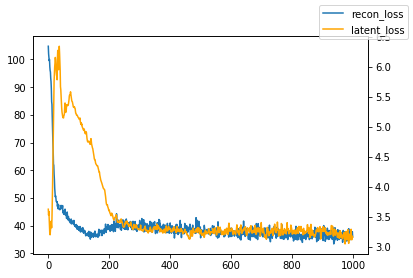

In [135]:
# plot the loss throughout the training
import matplotlib.pyplot as plt
%matplotlib inline

ax = plt.subplot(1, 1, 1)
ax.plot(losses.index, losses.recon_loss, label='recon_loss')

ax2 = ax.twinx()
ax2.plot(losses.index, losses.latent_loss, label='latent_loss', color='orange')
ax.figure.legend(loc='best')

In [75]:
# save the model
model.save_weights('./vae_1_weights.h5')

## Model perfomance with no lable at all

In [136]:
# evaluate
p_z = ds.MultivariateNormalDiag(loc=[0.] * model.hidden_size, scale_diag=[1.] * model.hidden_size)

test_tensor = tf.constant(X_test.values, dtype='float32')
# mu, sigma = tf.split(model.encoder(test_tensor), 2, 1)
encoded = model.encoder(test_tensor)
mu, sigma = model.dense_mean(encoded), model.dense_std(encoded)

q_z = ds.MultivariateNormalDiag(loc=mu, scale_diag=sigma)
test_pred = ds.kl_divergence(p_z, q_z)
# test_pred = tf.sigmoid(test_pred)

test_pred = test_pred.numpy()
test_pred = test_pred / (test_pred.max() - test_pred.min())

In [56]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, test_pred)

0.7206637173549073

## Use labels to generate oversampled data

In [137]:
# number of positive samples to generate so the minority class has the same amount as majority clas
n = (y_train == 0).sum() - (y_train==1).sum()
print('Need to generate {} positive samples.'.format(n))

Need to generate 3627 positive samples.


In [138]:
X_train_pos = X_train[y_train==1]

_, _, ds_pos = model.encode(X_train_pos.values)
sample_pos = ds_pos.sample(sample_shape=(n // y_train.sum()) + 1, seed=1024)
sample_pos = tf.reshape(sample_pos, [-1, model.hidden_size])
sample_pos = model.decode(sample_pos)
sample_pos.shape

TensorShape([3933, 36])

In [139]:
# append new samples to original samples
X_ = np.r_[X_train.values, sample_pos.numpy()[:n, ...]]
y_ = np.append(y_train, [1] * n)

# shuffle it 
from sklearn.utils import shuffle
X_, y_ = shuffle(X_, y_, random_state=1024)

In [140]:
clf.fit(X_, y_)

evaluate(clf)

AUC: 0.9438128612805063
Recall: 0.5691489361702128
Precision: 0.7588652482269503
F1: 0.6504559270516718

